## MBA em Ciência de Dados
# Redes Neurais e Arquiteturas Profundas

### <span style="color:darkred">Módulo 6 - Redes neurais para dados sequenciais</span>

#### <span style="color:darkred">**Parte 1: LSTMs e GRUs**</span>

Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

In [1]:
import numpy as np
from pandas import read_csv
#from pandas import datetime

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from numpy.random import seed
from tensorflow.random import set_seed

from sklearn.metrics import mean_squared_error
from math import sqrt

# outros 
df = read_csv('data/Alcohol_Sales.csv') 
#df = read_csv('data/Miles_Traveled.csv')
#df = read_csv('data/starbucks.csv') 
#df = read_csv('data/passengers.csv')
#df = read_csv('data/price_of_ground_chuck.csv') 

# pega segunda coluna do dataframe
var = df.columns.values[1]

Série:  S4248SM144NCEN
Tamanho da série:  325


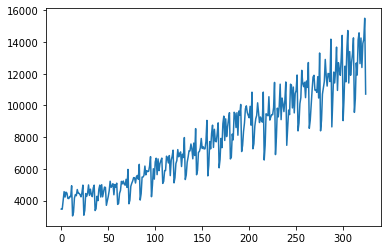

In [2]:
series = np.array(df[var])
plt.plot(series)
N = series.shape[0]

print("Série: ", var)
print("Tamanho da série: ", N)

## Parte 1: Preparando os dados

1. **Separação em treinamento e teste**: o treinamento sempre deve vir antes do teste no caso de dados sequenciais
2. **Normalização**: aqui utilizaremos a normalização Min-Max para 0-1
3. **Inserção de ruído opcional**: no treinamento e teste para avaliação da robustez dos modelos
4. **Formulação como aprendizado supervisionado**: adequando os arrays de forma a permitir uso nas redes neurais

In [3]:
# variaveis que definem divisao em treinamento e teste e controlam adição de ruído
porc_treinamento = 70
inserir_ruido_serie = False
inserir_ruido_teste = False
porc_ruido = 1

In [4]:
# calcula tamanhos dos dados de treinamento (n_train) e teste (n_test)
n_train = int(len(series)*(porc_treinamento/100.0))
n_test = len(series)-n_train+1

train_x = series[:n_train]
test_x = series[n_train-1:]

# normalização min-max com base no treinamento
vmax = train_x.max()
vmin = train_x.min()

train_x_norm = (train_x - vmin)/(vmax - vmin)
test_x_norm = (test_x - vmin)/(vmax - vmin)

print("Exemplos de Treinamento: ", n_train)
print("Exemplos de Teste: ", n_test)

Exemplos de Treinamento:  227
Exemplos de Teste:  99


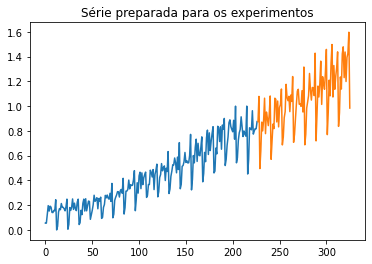

In [5]:
seed(1)
set_seed(1)

# insere ruido na serie
if (inserir_ruido_serie):
    train_x_norm = train_x_norm + np.random.randn(n_train)*(porc_ruido/100.0)

# insere ruido apenas no teste
if (inserir_ruido_teste):
    test_x_norm = test_x_norm + np.random.randn(n_test)*(porc_ruido/100.0)
    
plt.plot(np.arange(0, n_train), train_x_norm)
plt.plot(np.arange(n_train,n_train+n_test), test_x_norm)
ax = plt.title('Série preparada para os experimentos')

#### Formulação para aprendizado supervisionado: adequação dos arrays

Podemos cumprir essa etapa utilizando a observação do último passo $t-1$ como entrada e a observação atual $t$ como saída.

Podemos alcançar isso deslocando todos os valores da série por um número específico de posições. Aqui vamos deslocar 1 posição para trás, que se tornarão as variáveis de entrada, sendo que a série temporal original será considerada como a variável de saída.

In [6]:
# modifica a serie temporal tornando-a um problema de aprendizado supervisionado
# retornando array de entrada x e de saída y
def timeseries_to_supervised_dense(series, look_back=1):
    # o reshape com -1 preenche a dimensão conforme necessário, nesse caso teremos (num_valores, 1)
    x = np.reshape(np.array(series[:-look_back]), (-1, 1))
    y = np.reshape(np.array(series[look_back:]), (-1, 1))
    #y = np.array(series[shift:], copy=True)
    return x, y

In [7]:
look_back = 1
train_x_dense, train_y_dense = timeseries_to_supervised_dense(train_x_norm, look_back=look_back)

# numero de features na série
no_features = train_x_dense.shape[1]

print('Tamanho dos arrays de treinamento x e y')
print(train_x_dense.shape)
print(train_y_dense.shape)

print('\nPrimeiros 4 elementos de x e y')
print(train_x_dense[-4:])
print(train_y_dense[-4:])

Tamanho dos arrays de treinamento x e y
(226, 1)
(226, 1)

Primeiros 4 elementos de x e y
[[0.77393753]
 [0.79902714]
 [0.81784434]
 [0.81694828]]
[[0.79902714]
 [0.81784434]
 [0.81694828]
 [0.874936  ]]


## Parte 2: Utilizando unidades Densas para predição

Vamos tentar aprender a partir da série para obter um tipo de regressão

In [8]:
seed(1)
set_seed(1)

MLP = keras.Sequential()
MLP.add(keras.layers.InputLayer((None, no_features)))
MLP.add(keras.layers.Dense(16, activation='relu'))
MLP.add(keras.layers.Dense(32, activation='relu'))
MLP.add(keras.layers.Dropout(0.2))
MLP.add(keras.layers.Dense(1, activation='relu'))
MLP.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, None, 16)          32        
_________________________________________________________________
dense_1 (Dense)              (None, None, 32)          544       
_________________________________________________________________
dropout (Dropout)            (None, None, 32)          0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           33        
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


In [9]:
batch_size = 1
epochs = 80

# decaimento de learning rate
def scheduler(epoch, lr):
    if (epoch % 20 == 0): print("Época %04d - learning rate %.9f" % (epoch, lr))
    if (epoch+1 < 5):
        return lr
    else:
        return np.round(lr * tf.math.exp(-0.01),9)

callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

# compilacao e treinamento
MLP.compile(loss='mean_squared_error', 
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['mae'])

histMLP = MLP.fit(train_x_dense, train_y_dense,  
                  batch_size=batch_size, epochs=epochs,
                  callbacks=[callbacklr], 
                  verbose=0)

Época 0000 - learning rate 0.000100000
Época 0020 - learning rate 0.000085215
Época 0040 - learning rate 0.000069766
Época 0060 - learning rate 0.000057120


Scores treinamento
MSE: 0.0144
MAE: 0.0864


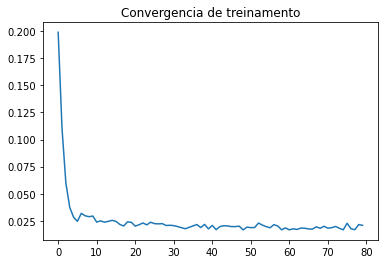

In [10]:
scores = MLP.evaluate(train_x_dense, train_y_dense, verbose=0)
print('Scores treinamento')
print('MSE: %.4f' % (scores[0]))
print('MAE: %.4f' % (scores[1]))

plt.plot(histMLP.history['loss'])
ax = plt.title('Convergencia de treinamento')

In [11]:
test_x_dense, test_y_dense = timeseries_to_supervised_dense(test_x_norm, look_back=look_back)

print('Tamanho dos arrays de teste x e y')
print(test_x_dense.shape)
print(test_y_dense.shape)

print('\nPrimeiros 4 elementos de teste x e y')
print(test_x_dense[-4:])
print(test_y_dense[-4:])

Tamanho dos arrays de teste x e y
(98, 1)
(98, 1)

Primeiros 4 elementos de teste x e y
[[1.19879672]
 [1.39311316]
 [1.42639529]
 [1.59664619]]
[[1.39311316]
 [1.42639529]
 [1.59664619]
 [0.98399898]]


In [12]:
# realiza predicoes com os dados de treinamento e teste
train_y_pred = MLP.predict(train_x_dense)
train_y_pred = np.reshape(train_y_pred, (-1, 1))[1:]

test_y_pred = MLP.predict(test_x_dense)
test_y_pred = np.reshape(test_y_pred, (-1, 1))[1:]

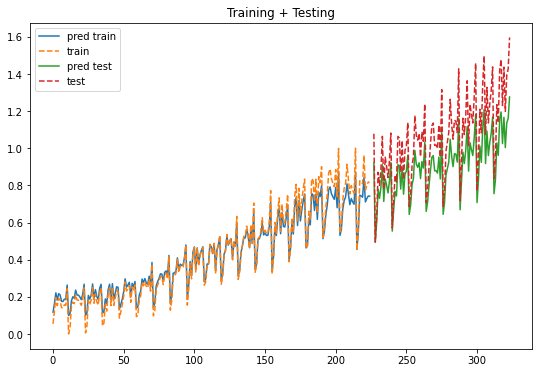

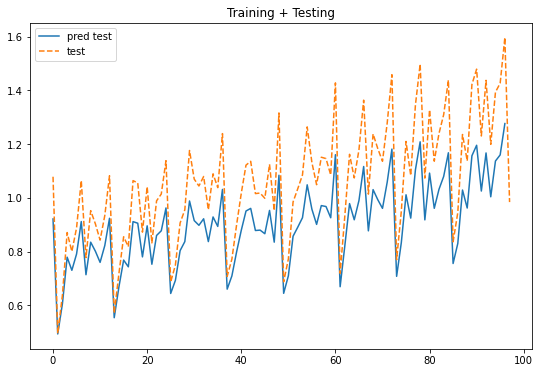

In [13]:
fig = plt.figure(figsize=(9,6))
plt.plot(train_y_pred, label='pred train')
plt.plot(train_y_dense[:-1],'--', label ='train')
plt.plot(np.arange(n_train,n_train+n_test-2), test_y_pred, label='pred test')
plt.plot(np.arange(n_train,n_train+n_test-2), test_y_dense[:-1], '--', label='test')
plt.legend()
axt = plt.title('Training + Testing')
plt.show()

fig = plt.figure(figsize=(9,6))
plt.plot(test_y_pred, label='pred test')
plt.plot(test_y_dense, '--', label='test')
plt.legend()
axt = plt.title('Training + Testing')
plt.show()


## Parte 3 : Utilizando LSTMs para predição

Agora utilizaremos uma rede neural baseada em camada recorrente, permitindo aprender a sequência.

Uma camada LSTM espera como entrada uma matriz com as seguintes dimensões:

samples x time_steps x features

* *Samples* são as observações independentes do domínio, tipicamente colunas de dados, consideradas no batch

* *Time steps* são os passos temporais separados de uma dada variável para uma dada observação - quantas observações serão dadas como entrada antes de que a primeira saída seja obtida

* *Features* são as medidas separadas observada em cada tempo da observação - quantos valores são considerados em cada entrada

No caso dessa base de dados, podemos usar diferentes configurações. Para manter simples, consideramos que o problema em cada passo de tempo é uma amostra individual, com um time step e uma feature apenas.


In [14]:
# formato deve ser um tensor: [samples, time steps, features]
# time_steps é o número de observações de entrada antes da 1a.previsão
# features é o número de valores em cada entrada (univariada, multivariada)
def recurrent_array(train_x,time_steps=1):
    
    array = np.array(np.reshape(train_x, (-1, 1)), copy=True)
    
    train_y_ts = array[time_steps:]
    train_x_ts = []
    for i in range(0, len(array) - time_steps):
        train_x_ts.append(array[i:i+time_steps])
        
    train_x_ts = np.array(train_x_ts)
    
    #rec_array = np.reshape(array, (array.shape[0], time_steps, array.shape[1]))
    return train_x_ts, train_y_ts

In [15]:
time_steps = 2

train_x_rec, train_y_rec = recurrent_array(train_x_norm, time_steps=time_steps)

test_x_rec, test_y_rec = recurrent_array(test_x_norm,time_steps=time_steps)

In [16]:
print('Dados de treinamento para rede recorrente')
print('Tamanho dos arrays de teste x e y')
print('Tensor de Entrada x:',train_x_rec.shape)
print('Saída y (número de predições, univariada x multivariada):', train_y_rec.shape)

print('\nPrimeiros 4 elementos de teste x e 4 do y')
print('x:',train_x_rec[:4])
print('y:',train_y_rec[:4])

Dados de treinamento para rede recorrente
Tamanho dos arrays de teste x e y
Tensor de Entrada x: (225, 2, 1)
Saída y (número de predições, univariadaxmultivariada: (225, 1)

Primeiros 4 elementos de teste x e 6 do y
x: [[[0.05478751]
  [0.0546595 ]]

 [[0.0546595 ]
  [0.12429595]]

 [[0.12429595]
  [0.19623656]]

 [[0.19623656]
  [0.15232975]]]
y: [[0.12429595]
 [0.19623656]
 [0.15232975]
 [0.19175627]]


In [17]:
# Comparando com o train_x usado para treinar a MLP
train_x_dense[:6]

array([[0.05478751],
       [0.0546595 ],
       [0.12429595],
       [0.19623656],
       [0.15232975],
       [0.19175627]])

#### Rede com unidades LSTM

Aqui entram as camadas LSTM em lugar das Dense da MLP <br>
return_sequences=True se quiser usar o sumário (memória) <br>
return_sequences=True obrigatoriamente se na 1a.camada LSTM se tiver 2 camadas LSTM <br>
LSTM tem vários portões que é como se tivesse várias camadas a mais, portanto terá mais parâmetros <br>

In [18]:
batch_size = 1

seed(1)
set_seed(1)

modelLSTM = keras.models.Sequential()
modelLSTM.add(keras.layers.InputLayer((None, no_features)))
modelLSTM.add(keras.layers.LSTM(16, return_sequences=True, activation='relu')) # 32
modelLSTM.add(keras.layers.LSTM(32, activation='relu'))
modelLSTM.add(keras.layers.Dropout(0.2))
modelLSTM.add(keras.layers.Dense(1, activation='relu'))
modelLSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 16)          1152      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 7,457
Trainable params: 7,457
Non-trainable params: 0
_________________________________________________________________


In [19]:
epochs = 80

# decaimento de learning rate
def scheduler(epoch, lr):
    if (epoch % 20 == 0): print("Época %04d - learning rate %.9f" % (epoch, lr))
    if (epoch+1 < 5):
        return lr
    else:
        return np.round(lr * tf.math.exp(-0.01),9)

callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

# compilacao e treinamento
modelLSTM.compile(loss='mean_squared_error', 
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['mae'])

histLSTM = modelLSTM.fit(train_x_rec, train_y_rec,  
                  batch_size=batch_size, epochs=epochs,
                  callbacks=[callbacklr], shuffle=False,
                  verbose=0)

Época 0000 - learning rate 0.000100000
Época 0020 - learning rate 0.000085215
Época 0040 - learning rate 0.000069766
Época 0060 - learning rate 0.000057120


Scores treinamento
MSE: 0.0134
MAE: 0.0882


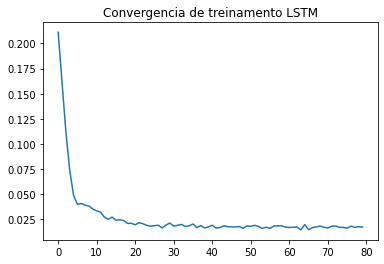

In [20]:
scores = modelLSTM.evaluate(train_x_rec, train_y_rec, verbose=0)
print('Scores treinamento')
print('MSE: %.4f' % (scores[0]))
print('MAE: %.4f' % (scores[1]))

plt.plot(histLSTM.history['loss'])
ax = plt.title('Convergencia de treinamento LSTM')

In [21]:
# realiza predicoes com os dados de treinamento e teste
train_y_predL = modelLSTM.predict(train_x_rec)
train_y_predL = np.reshape(train_y_predL, (-1, 1))[time_steps:]

test_y_predL = modelLSTM.predict(test_x_rec)
test_y_predL = np.reshape(test_y_predL, (-1, 1))[time_steps:]

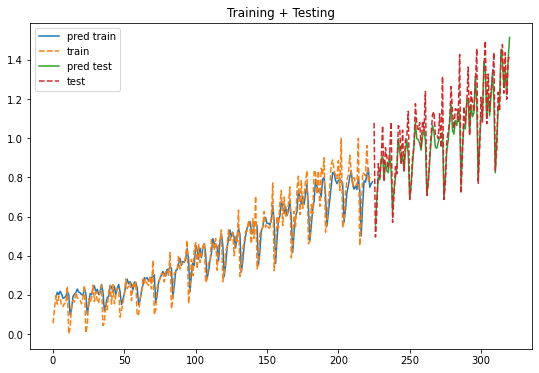

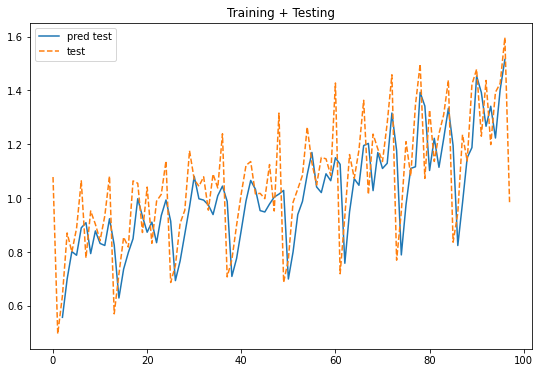

In [22]:
fig = plt.figure(figsize=(9,6))
plt.plot(np.arange(time_steps,len(train_y_predL)+time_steps), train_y_predL, label='pred train')
plt.plot(train_y_dense[:-time_steps],'--', label ='train')
plt.plot(np.arange(len(train_y_predL)+time_steps+1, len(train_y_predL)+time_steps+len(test_y_predL)+1), test_y_predL, label='pred test')
plt.plot(np.arange(len(train_y_predL)+time_steps, len(train_y_predL)+time_steps+len(test_y_dense[:-time_steps])), test_y_dense[:-time_steps], '--', label='test')
plt.legend()
axt = plt.title('Training + Testing')
plt.show()

fig = plt.figure(figsize=(9,6))
plt.plot(np.arange(time_steps, len(test_y_predL)+time_steps), test_y_predL, label='pred test')
plt.plot(test_y_dense, '--', label='test')
plt.legend()
axt = plt.title('Training + Testing')
plt.show()


#### GRU como forma alternativa à LSTM

Entram as camadas GRU em lugar das LSTM <br>
Tem menos parâmetros porque a GRU tem menos portões que a LSTM <br>

In [23]:
batch_size = 1

seed(1)
set_seed(1)
GRU = keras.models.Sequential()
GRU.add(keras.layers.InputLayer((None, no_features)))
GRU.add(keras.layers.GRU(32, return_sequences=True, activation='relu')) # 32
GRU.add(keras.layers.GRU(32, activation='relu'))
GRU.add(keras.layers.Dropout(0.2))
GRU.add(keras.layers.Dense(1, activation='relu'))
GRU.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 32)          3360      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________


In [24]:
epochs = 80

# decaimento de learning rate
def scheduler(epoch, lr):
    if (epoch % 20 == 0): print("Época %04d - learning rate %.9f" % (epoch, lr))
    if (epoch+1 < 5):
        return lr
    else:
        return np.round(lr * tf.math.exp(-0.01),9)

callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

# compilacao e treinamento
GRU.compile(loss='mean_squared_error', 
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['mae'])

histGRU = GRU.fit(train_x_rec, train_y_rec,  
                  batch_size=batch_size, epochs=epochs,
                  callbacks=[callbacklr], shuffle=False,
                  verbose=0)

Época 0000 - learning rate 0.000100000
Época 0020 - learning rate 0.000085215
Época 0040 - learning rate 0.000069766
Época 0060 - learning rate 0.000057120


Scores treinamento
MSE: 0.0126
MAE: 0.0847


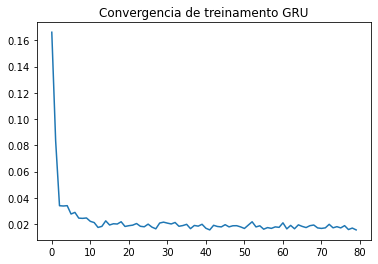

In [25]:
scores = GRU.evaluate(train_x_rec, train_y_rec, verbose=0)
print('Scores treinamento')
print('MSE: %.4f' % (scores[0]))
print('MAE: %.4f' % (scores[1]))

plt.plot(histGRU.history['loss'])
ax = plt.title('Convergencia de treinamento GRU')

In [26]:
# realiza predicoes com os dados de treinamento e teste
train_y_predG = GRU.predict(train_x_rec)
train_y_predG = np.reshape(train_y_predG, (-1, 1))[time_steps:]

test_y_predG = GRU.predict(test_x_rec)
test_y_predG = np.reshape(test_y_predG, (-1, 1))[time_steps:]

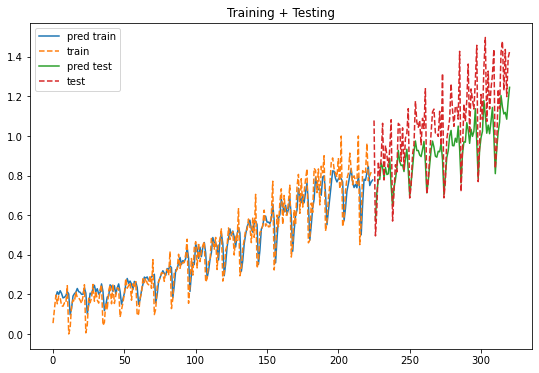

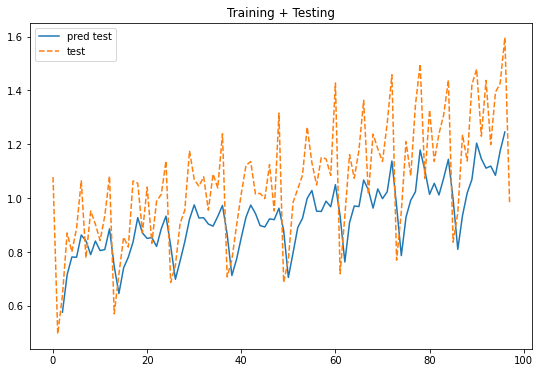

In [27]:
fig = plt.figure(figsize=(9,6))
plt.plot(np.arange(time_steps,len(train_y_predG)+time_steps), train_y_predL, label='pred train')
plt.plot(train_y_dense[:-time_steps],'--', label ='train')
plt.plot(np.arange(len(train_y_predG)+time_steps+1, len(train_y_predG)+time_steps+len(test_y_predG)+1), test_y_predG, label='pred test')
plt.plot(np.arange(len(train_y_predG)+time_steps, len(train_y_predG)+time_steps+len(test_y_dense[:-time_steps])), test_y_dense[:-time_steps], '--', label='test')
plt.legend()
axt = plt.title('Training + Testing')
plt.show()

fig = plt.figure(figsize=(9,6))
plt.plot(np.arange(time_steps,len(test_y_predG)+time_steps),test_y_predG, label='pred test')
plt.plot(test_y_dense, '--', label='test')
plt.legend()
axt = plt.title('Training + Testing')
plt.show()

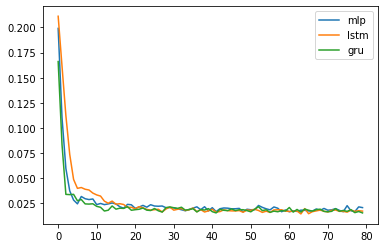

In [28]:
plt.plot(histMLP.history['loss'])
plt.plot(histLSTM.history['loss'])
plt.plot(histGRU.history['loss'])
plt.legend(['mlp', 'lstm', 'gru'])

In [29]:
# avaliacao da predição ponto a ponto
print("Erro no teste com predição a cada ponto:")
scoreMLP = MLP.evaluate(test_x_dense, test_y_dense, verbose=0)
print("MLP: %.5f" % (scoreMLP[0]))
scoreLSTM = modelLSTM.evaluate(test_x_rec, test_y_rec, verbose=0)
print("LSTM: %.5f" % (scoreLSTM[0]))
scoreGRU = GRU.evaluate(test_x_rec, test_y_rec, verbose=0)
print("GRU: %.5f" % (scoreGRU[0]))

Erro no teste com predição a cada ponto:
MLP: 0.06809
LSTM: 0.05206
GRU: 0.05784


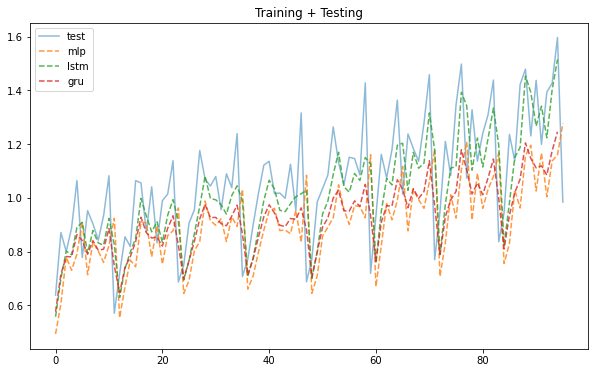

In [30]:
fig = plt.figure(figsize=(10,6))
plt.plot(test_y_dense[time_steps:], '-', alpha=0.5, label='test')
plt.plot(test_y_pred[time_steps-1:], '--', alpha=0.8, label='mlp')
plt.plot(test_y_predL, '--', alpha=0.8, label='lstm')
plt.plot(test_y_predG, '--', alpha=0.8, label='gru')
plt.legend()
axt = plt.title('Training + Testing')
plt.show()